## 读入数据集

In [109]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from d2l import torch as d2l

train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


## 制作数据集

看一下前4个样本的前4个特征，后两个特征和标签

In [110]:
print(train_data.iloc[0:4, [0,1,2,3,-3,-2,-1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


可以看到第一个特征是Id，它能帮助模型记住每个训练样本，但难以推广到测试样本，所以我们不使用它来训练。

拼接数据集

In [111]:
all_features = pd.concat((train_data.iloc[:,1:-1], test_data.iloc[:,1:]))

## 数据预处理

#### 标准化
- 补充缺失值
- 每个特征数值减去均值再除以标准差

In [112]:
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / x.std())
# 标准化后，每个数据的均值为0，所以可以直接用0来替代缺失值。
all_features[numeric_features] = all_features[numeric_features].fillna(0)

#### 字符串特征稀疏表示
处理离散值。我们用独热编码替代。

In [113]:
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2919, 331)

转换成张量

In [114]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
train_labels = torch.tensor(train_data.SalePrice.values.reshape(-1,1), dtype=torch.float32)
print(train_features.shape)
print(test_features.shape)
print(train_labels.shape)

torch.Size([1460, 331])
torch.Size([1459, 331])
torch.Size([1460, 1])


## 训练模型


In [115]:
loss = torch.nn.MSELoss()
in_features = train_features.shape[1]

def get_net():
    net = nn.Sequential(
        nn.Linear(in_features, 128),
        nn.ReLU(),

        nn.Linear(128, 64),
        nn.ReLU(),

        nn.Linear(64, 32),
        nn.ReLU(),

        nn.Linear(32, 1)
        )
    return net

def log_rmse(net, features, labels):
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds), torch.log(labels)))
    return rmse.item()

def train(net, train_features, train_labels, test_features, test_labels, 
    num_epochs, learning_rate, weight_decay,batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate,weight_decay=weight_decay)

    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

### K折交叉验证

In [116]:
def get_k_fold_data(k,i,X,y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j+1)*fold_size)
        X_part, y_part = X[idx,:], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

In [117]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay, batch_size):
    train_l_sum, valid_l_sum = 0,0
    for i in range(k):
        data = get_k_fold_data(k, i , X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate, weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i==0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
            xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
            legend=['train','valid'], yscale='log')
        print(f'fold{i+1}, train log rmse {float(train_ls[-1])},'
            f'valid log rmse {float(valid_ls[-1]):f}')
    return train_l_sum /k, valid_l_sum / k

## 模型选择

fold1, train log rmse 0.1255086362361908,valid log rmse 0.145568
fold2, train log rmse 0.11564914137125015,valid log rmse 0.147006
fold3, train log rmse 0.11786296963691711,valid log rmse 0.145158
fold4, train log rmse 0.12078093737363815,valid log rmse 0.120465
fold5, train log rmse 0.11018562316894531,valid log rmse 0.157618
5-折验证：平均训练log rmse：0.117997,平均验证log rmse：0.143163


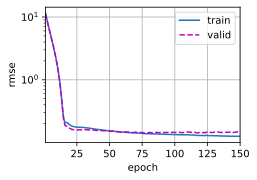

In [118]:
k, num_epochs, lr, weight_decay, batch_size = 5, 150, 0.001, 5, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr, weight_decay, batch_size)
print(f'{k}-折验证：平均训练log rmse：{float(train_l):f},'
    f'平均验证log rmse：{float(valid_l):f}')

train log rmse0.115940


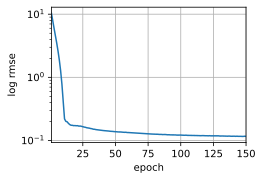

In [119]:
def train_and_pred(train_features, test_features, train_labels, test_data,
    num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels,None, None,
                    num_epochs,lr,weight_decay,batch_size)
    d2l.plot(np.arange(1, num_epochs+1), [train_ls], xlabel='epoch', 
            ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'train log rmse{float(train_ls[-1]):f}')
    preds = net(test_features).detach().numpy()
    test_data['SalePrice'] = pd.Series(preds.reshape(1,-1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

train_and_pred(train_features,test_features,train_labels,test_data,num_epochs,lr,weight_decay,batch_size)

